<a href="https://colab.research.google.com/github/danyentezari/bn-ocr/blob/main/keras_ocr_bignumber_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
# !unzip kaggle.json.zip
# !mkdir ~/.kaggle 
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download scolianni/mnistasjpg
# !unzip mnistasjpg.zip
!pip install 'h5py==2.10.0' --force-reinstall
# !pip install cairocffi
# !pip install gdown
# !pip install synthtiger

In [10]:
!rm -r ./out

In [ ]:
!pip install trdg

In [ ]:
!trdg -c 40000 -w 5 -f 64 --length 1

In [14]:
# !pip install synthtiger
# !git clone https://github.com/clovaai/synthtiger.git
# !cp -r synthtiger/* .
# !synthtiger -o results -w 4 -c 500 -v examples/synthtiger/template.py SynthTiger examples/synthtiger/config_horizontal.yaml

In [2]:
# !curl https://thor.robots.ox.ac.uk/~vgg/data/text/mjsynth.tar.gz --output mjsynth.tar.gz
# !tar -xvf ./mjsynth.tar.gz

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from scipy.sparse import csr_matrix
import cv2
import string
from PIL import Image

import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import keras
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import * #Conv2D, Lambda, MaxPooling2D # convolution layers
#from keras.layers import Dense, Dropout, Flatten # core layers
# from keras.layers.normalization import BatchNormalization


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# from tensorflow.keras.utils import load_img
# from tensorflow.keras.utils import img_to_array

from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
# from keras.layers import Input, Dense, Activation, Add
# from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
#from keras.metrics import Metric
from tensorflow.python.keras.metrics import Metric

import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

### Features and Labels

In [2]:
t1 = [[1, 2, 3], [4, 5, 6]]
t2 = [[7, 8, 9], [10, 11, 12]]
x = tf.concat([t1, t2], 0)
x.eval(session=tf.compat.v1.Session())

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]], dtype=int32)

In [50]:
cw = 100
ch = 32

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


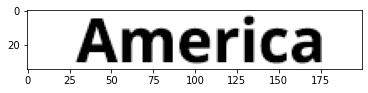

In [114]:
def loadImage(filepath):
  # img = load_img(filepath, target_size=(ch, cw), grayscale=True)
  img = load_img(filepath, grayscale=True)
  img = img_to_array(img)
  #img = img.reshape(1, 42, 42, 3)
  #img = img.reshape(32, 125, 3)
  img = img.astype('float32')
  # img = img / 255.0
  return img

plt.imshow(loadImage('./america.png')[:,:,0], cmap='gray')

In [5]:
# def scale_resize_image(image):
#     image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
#     image = tf.image.resize(image, (ch, cw))
#     return image


# someimg = load_img('./america.png')

# someimg = scale_resize_image( someimg )
# # someimg = someimg.astype('float32')

# plt.imshow( someimg.eval(session=tf.compat.v1.Session()) )

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


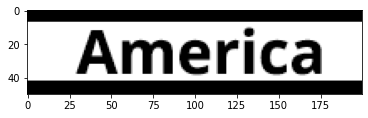

In [161]:
def create_canvas(canvas_h=300, canvas_w=300):
  # Create canvas
  canvas_color = 255

  pixel_rows = []
  row = [canvas_color for x in range(0,canvas_w)]
  for i in range(0,canvas_h):
    pixel_rows.append(row)
  r = pixel_rows
  g = pixel_rows
  b = pixel_rows

  canvas = np.dstack((r,g,b))
  return canvas

# cw = 950
# ch = 200
canvas = create_canvas(ch, cw)

def center_pad_image(img, canvas_h=300, canvas_w=300):

  canvas = np.zeros((canvas_h, canvas_w, 1)) #create_canvas(canvas_h, canvas_w)
  # Image positions
  img2_width = img.shape[1]
  img2_height = img.shape[0]
  black_row = np.array([[0 for x in range(0,img2_width)]])
  img2 = np.dstack((black_row,black_row,black_row))


  startx = int((canvas_w-img2_width)/2)
  starty = int((canvas_h-img2_height)/2)
  endx = startx + img2_width
  endy = starty + img2_height

  # Superimpose image
  to_superimpose = img #Image.fromarray(np.uint8(img)).convert('RGB')
  # Reset global canvas
  canvas[:, :] = 0
  canvas[starty:endy, startx:endx] = to_superimpose


  return canvas/255#Image.fromarray(np.uint8(canvas)).convert('RGB')


# center_pad_image(sample_image, ch, cw)
sample = center_pad_image(loadImage('./america.png'), 50, 200)
plt.imshow(sample[:,:,0], cmap='gray')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


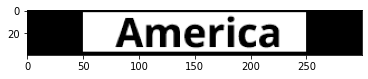

In [128]:
# center_pad_image(loadImage('./america.png'), 100, 800)

plt.imshow(center_pad_image(loadImage('./america.png'), 40, 300)[:,:,0], cmap='gray')

In [162]:
print(loadImage('./america.png').shape)
center_pad_image(loadImage('./america.png'), 50, 200).shape

(35, 200, 1)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(50, 200, 1)

In [7]:
# def create_canvas(canvas_h=300, canvas_w=300):
#   # Create canvas
#   canvas_color = 0

#   pixel_rows = []
#   row = [canvas_color for x in range(0,canvas_w)]
#   for i in range(0,canvas_h):
#     pixel_rows.append(row)
#   r = pixel_rows
#   g = pixel_rows
#   b = pixel_rows

#   canvas = np.dstack((r,g,b))
#   return canvas

# # cw = 300
# # ch = 100
# canvas = create_canvas(ch, cw)

# def negative_pad_image(img, canvas_h=300, canvas_w=300):
#   # Image positions
#   img2_width = img.shape[1]
#   img2_height = img.shape[0]
#   black_row = np.array([[0 for x in range(0,img2_width)]])
#   img2 = np.dstack((black_row,black_row,black_row))


#   startx = 0#int((canvas_w-img2_width)/2)
#   starty = 0#int((canvas_h-img2_height)/2)
#   endx = startx + img2_width
#   endy = starty + img2_height

#   # Superimpose image
#   to_superimpose = img # Image.fromarray(np.uint8(img)).convert('RGB')
#   # Reset global canvas
#   canvas[:, :] = 0 #255
#   canvas[starty:endy, startx:endx] = to_superimpose


#   return canvas #Image.fromarray(np.uint8(canvas)).convert('RGB')

In [8]:
# a = tf.constant([[[0], [0], [0]]])
# b = tf.constant([[[0], [0], [0]]])

# x = tf.concat([a, b], 0)
# print(x.eval(session=tf.compat.v1.Session()))
# print(x.shape)

In [9]:
# a = tf.constant( np.empty((1, ch, cw, 3)), dtype='float32')
# b = tf.constant([[0, 0, 0]])
# c = tf.constant( np.empty((1, ch, cw, 3)), dtype='float32')


# x = tf.concat([a, c], 0)
# # print(x.eval(session=tf.compat.v1.Session()))
# print(x.shape)

In [10]:
# import re
# file1 = open('./results/gt.txt', 'r')
# Lines = file1.readlines()


# data_F = [] # np.array([])#np.empty((n, ch, cw, 3))
# data_L = [] # np.array([])

# n = 0
# count = 0
# # Strips the newline character
# for i,line in enumerate(Lines[0:2000]):
#     d = re.split('\t', line)
#     d[1] = d[1].replace('\n','')

#     img = loadImage(f'results/{d[0]}')
#     #img = load_img(f'results/{d[0]}')

#     # if( img.shape[0] <= ch and img.shape[0] >= 20 and img.shape[1] <= cw and img.shape[1] >= 80):

#     n += 1
#     # loaded_image = img.astype(np.uint8)
#     # loaded_image = np.array(negative_pad_image(img, ch, cw))

#     # data_F[i] = loaded_image
#     # data_L = np.append(data_L, d[1])

#     # loaded_image = scale_resize_image(img)
#     # loaded_image = loaded_image / 255
#     data_F.append(img)
#     data_L.append(d[1])


# data_F = np.array(data_F)
# data_L = np.array(data_L)
# data_F.reshape(2000, 80, 200, 3)
# print(data_F.shape)
# # Image.fromarray(np.uint8(data_F[0])).convert('RGB')
# #plt.imshow( data_F[0].eval(session=tf.compat.v1.Session()) )


# # img = sample_image.astype(np.uint8) 
# # img = np.array(negative_pad_image(img, ch, cw))
# # plt.imshow(img)

# plt.imshow(data_F[0])

In [132]:
ch = 64
cw = 400

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


max_width 400
(29138, 64, 400, 1)


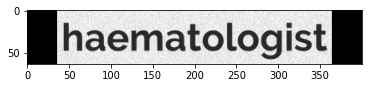

In [316]:
import os


data_F = []
data_L = []

n_images = len( os.listdir("./out"))
n_images = 30000

max_width = 0

for fi in os.listdir("./out")[0:n_images]:
    d = re.split('_', fi)

    img = loadImage(f'./out/{fi}')

    if ( img.shape[1] <= 400 ):
      if(img.shape[1] > max_width):
        max_width = img.shape[1]
      img = center_pad_image(img, ch, cw)

      data_F.append(img)
      data_L.append(d[0])

n_images = len(data_F)
print('max_width', max_width)
data_F = np.array(data_F)
data_L = np.array(data_L)
data_F.reshape(n_images, ch, cw, 1)
print(data_F.shape)
plt.imshow(data_F[0][:,:,0], cmap='gray')

In [317]:
n = n_images

In [318]:
# # data_F[0].eval(session=tf.compat.v1.Session())
# print(data_F.shape)
# print(n)
# print(len(Lines))

In [319]:
# plt.imshow(data_F[0])

# # print(data_F[10])
# print(data_L[10])
# print(x.shape)
# print(img.shape)

In [320]:
#alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ./:;,\'"-_1234567890?!)(][}{><=*@#$%^&|~+`'
alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_-1234567890.'
alph_num = re.split('', alphabet)
alph_dict = dict({})

# alph_num.pop(0)
for j, c in enumerate(alph_num):
  alph_dict[c] = j

In [321]:
s = 'better'
alph_dict
_id = list(map(lambda c: alph_dict[c], s))
_id
# data_L_dist = to_categorical(data_L[0])

[2, 5, 20, 20, 5, 18]

In [322]:
len(alph_dict)

66

In [355]:
m = lambda x: [alph_dict[c] for c in x]

data_L_id = np.zeros((n,100))
data_L_id = data_L_id -1
for k,data in enumerate(data_L):
  # data = data.lower()
  ids = m(data)
  # data_L_id = np.append(data_L_id, [ids], axis=0)
  data_L_id[k][0:len(ids)] = ids[:]
  # data_L_id = np.append(data_L_id, m(data), axis=0)

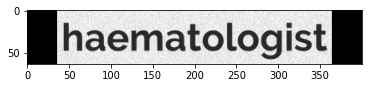

In [324]:
plt.imshow(data_F[0][:,:,0], cmap='gray')

In [356]:
data_L_id[0]

array([ 8.,  1.,  5., 13.,  1., 20., 15., 12., 15.,  7.,  9., 19., 20.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [325]:
data_L[0]

'haematologist'

In [357]:
data_L_dist = to_categorical(data_L_id)

In [327]:
data_L_dist.shape

(29138, 100, 64)

In [358]:
data_L_dist[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [328]:
data_F.shape

(29138, 64, 400, 1)

In [329]:
len(alphabet)

65

In [330]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# data_F_scaled = data_F.reshape(n_images, 40 * 100 * 3)
# data_F_scaled = scaler.transform(data_F_scaled)

In [331]:
#data_F_scaled = data_F_scaled.reshape(n_images, 40, 100, 3)

### Model

In [332]:
train_F, test_F, train_L_dist, test_L_dist = train_test_split(data_F, data_L_dist, test_size=0.2, random_state=0)

In [333]:
# train_F, test_F, train_L_dist, test_L_dist = train_test_split(data_F_scaled, data_L_dist, test_size=0.2, random_state=0)

In [334]:
train_F.shape, test_F.shape, train_L_dist.shape, test_L_dist.shape

((23310, 64, 400, 1), (5828, 64, 400, 1), (23310, 100, 64), (5828, 100, 64))

In [335]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        # featurewise_center=False,  # set input mean to 0 over the dataset
        # samplewise_center=False,  # set each sample mean to 0
        # featurewise_std_normalization=False,  # divide inputs by std of the dataset
        # samplewise_std_normalization=False,  # divide each input by its std
        # zca_whitening=False,  # apply ZCA whitening
        # rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = 0.01, # Randomly zoom image 
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(train_F, train_L_dist, batch_size=10)
test_gen = datagen.flow(test_F, test_L_dist, batch_size=10)

In [336]:
epochs = 100
batch_size = 128
train_steps = train_F.shape[0] // batch_size
valid_steps = test_F.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [346]:
img_w = cw
img_h = ch
words_per_epoch = 16000
val_split = 0.2
val_words = int(words_per_epoch * (val_split))

# Network parameters
conv_filters = 32
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 16
rnn_size = 128

input_shape = (ch, cw, 1)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2),
                    (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True,
              go_backwards=True, kernel_initializer='he_normal',
              name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
              kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(
              64,# len(alphabet) + 1, 
              kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b])
            )
y_pred = Activation('softmax', name='softmax')(inner)

prediction_model = Model(inputs=input_data, outputs=y_pred)
prediction_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

prediction_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 64, 400, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 400, 32)  320         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 32, 200, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 32, 200, 32)  9248        max1[0][0]                       
___________________________________________________________________________________________

In [347]:
# prediction_model.fit(
#     data_F, 
#     data_L_dist, 
#     validation_split=0.2,
#     shuffle=True,
#     epochs=10
#   )

In [348]:
# Fit the model
metrics1 = prediction_model.fit_generator(train_gen, 
                              epochs = 5, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp]
                              )

Epoch 1/5
182/182 [==============================] - 83s 453ms/step - loss: 0.3732 - acc: 0.9086 - val_loss: 0.3092 - val_acc: 0.9126
Epoch 2/5
182/182 [==============================] - 75s 411ms/step - loss: 0.3017 - acc: 0.9149 - val_loss: 0.3005 - val_acc: 0.9144
Epoch 3/5
182/182 [==============================] - 75s 412ms/step - loss: 0.2982 - acc: 0.9158 - val_loss: 0.3005 - val_acc: 0.9149
Epoch 4/5
182/182 [==============================] - 74s 407ms/step - loss: 0.2984 - acc: 0.9156 - val_loss: 0.2951 - val_acc: 0.9160
Epoch 5/5
182/182 [==============================] - 76s 416ms/step - loss: 0.2995 - acc: 0.9146 - val_loss: 0.3033 - val_acc: 0.9141


In [349]:
print(len(alphabet))
print(train_L_dist.shape)

65
(23310, 100, 64)


### Model 2

In [350]:

# class CTCLayer(keras.layers.Layer):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = keras.backend.ctc_batch_cost

#     def call(self, y_true, y_pred):
#         batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
#         input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
#         label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

#         input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
#         loss = self.loss_fn(y_true, y_pred, input_length, label_length)
#         self.add_loss(loss)

#         # At test time, just return the computed predictions.
#         return y_pred


# def build_model():
#     # Inputs to the model
#     input_img = keras.Input(shape=(cw, ch, 1), name="image")
#     labels = keras.layers.Input(name="label", shape=(None,))

#     # First conv block.
#     x = keras.layers.Conv2D(
#         32,
#         (3, 3),
#         activation="relu",
#         kernel_initializer="he_normal",
#         padding="same",
#         name="Conv1",
#     )(input_img)
#     x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

#     # Second conv block.
#     x = keras.layers.Conv2D(
#         64,
#         (3, 3),
#         activation="relu",
#         kernel_initializer="he_normal",
#         padding="same",
#         name="Conv2",
#     )(x)
#     x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

#     # We have used two max pool with pool size and strides 2.
#     # Hence, downsampled feature maps are 4x smaller. The number of
#     # filters in the last layer is 64. Reshape accordingly before
#     # passing the output to the RNN part of the model.
#     new_shape = ((cw // 4), (ch // 4) * 64)
#     x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
#     x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
#     x = keras.layers.Dropout(0.2)(x)

#     # RNNs.
#     x = keras.layers.Bidirectional(
#         keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
#     )(x)
#     x = keras.layers.Bidirectional(
#         keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
#     )(x)

#     # +2 is to account for the two special tokens introduced by the CTC loss.
#     # The recommendation comes here: https://git.io/J0eXP.
#     x = keras.layers.Dense(
#         len(alphabet) + 1, activation="softmax", name="dense2"
#     )(x)

#     # Add CTC layer for calculating CTC loss at each step.
#     output = CTCLayer(name="ctc_loss")(labels, x)

#     # Define the model.
#     model = keras.models.Model(
#         inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
#     )
#     # Optimizer.
#     opt = keras.optimizers.Adam()
#     # Compile the model and return.
#     model.compile(optimizer=opt)
#     return model


# # Get the model.
# model = build_model()
# model.summary()

In [351]:

# def calculate_edit_distance(labels, predictions):
#     # Get a single batch and convert its labels to sparse tensors.
#     saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

#     # Make predictions and convert them to sparse tensors.
#     input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
#     predictions_decoded = keras.backend.ctc_decode(
#         predictions, input_length=input_len, greedy=True
#     )[0][0][:, :max_len]
#     sparse_predictions = tf.cast(
#         tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
#     )

#     # Compute individual edit distances and average them out.
#     edit_distances = tf.edit_distance(
#         sparse_predictions, saprse_labels, normalize=False
#     )
#     return tf.reduce_mean(edit_distances)


# class EditDistanceCallback(keras.callbacks.Callback):
#     def __init__(self, pred_model):
#         super().__init__()
#         self.prediction_model = pred_model

#     def on_epoch_end(self, epoch, logs=None):
#         edit_distances = []

#         for i in range(len(validation_images)):
#             labels = validation_labels[i]
#             predictions = self.prediction_model.predict(validation_images[i])
#             edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

#         print(
#             f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
#         )


### Predict

'seeeeeoneeee'

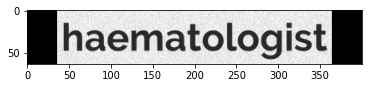

In [352]:
plt.imshow(data_F[0][:,:,0], cmap='gray')

yhat2 = prediction_model.predict(data_F[0].reshape(1,ch,cw,1))

r = ''
for i in range(15):
  r += alph_num[yhat2[0][i].argmax()]

r

In [353]:
alph_num[data_L_dist[0][1].argmax()]

'a'

In [ ]:
sample_image = loadImage('./america.png')
#loaded_image = np.array(negative_pad_image(img, ch, cw))
#loaded_image = loaded_image / 255

yhat2 = prediction_model.predict(sample_image.reshape(1,ch,cw,1))

r = ''
for i in range(15):
  r += alph_num[yhat2[0][i].argmax()]

r

In [ ]:
# View sample image and predicted label together

sample_image = loadImage('./results/images/0/0.jpg')
# Image.fromarray(np.uint8(sample_image*255)).convert('RGB')
img = sample_image.astype(np.uint8) 
#img = np.array(negative_pad_image(img, ch, cw))

plt.imshow(sample_image)

yhat = prediction_model.predict(img.reshape(1, ch, cw, 3))
yhat.shape

print(yhat.shape)
print(yhat)
print(yhat[0][3].argmax())

In [ ]:
x = img.astype(np.uint8)
plt.imshow(x)